In [1]:
# ================================================================
# 📘 ACADEMICALLY VALID ML PIPELINE
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load & Preprocess Data
# -----------------------------
df = pd.read_csv("Mobile Reviews Sentiment.csv")

EXCHANGE_RATE = 87
df['price_inr'] = df['price_usd'] * EXCHANGE_RATE
df['is_positive'] = (df['sentiment'] == "Positive").astype(int)

df['review_date'] = pd.to_datetime(df['review_date'])
df['month_year'] = df['review_date'].dt.to_period('M')

# -----------------------------
# 2. Phone-Level Aggregation
# -----------------------------
phone_stats = df.groupby(['brand', 'model']).agg({
    'price_inr': 'mean',
    'battery_life_rating': 'mean',
    'camera_rating': 'mean',
    'performance_rating': 'mean',
    'design_rating': 'mean',
    'display_rating': 'mean',
    'is_positive': 'mean',
    'review_id': 'count'
}).reset_index()

phone_stats.rename(columns={'is_positive': 'sentiment_score',
                            'review_id': 'popularity'}, inplace=True)

# -----------------------------
# 3. Target Definition (Strategy B)
# -----------------------------
sent_thresh = phone_stats['sentiment_score'].quantile(0.75)
pop_thresh = phone_stats['popularity'].median()

phone_stats['is_successful'] = (
    (phone_stats['sentiment_score'] > sent_thresh) &
    (phone_stats['popularity'] > pop_thresh)
).astype(int)

print("Class Balance:\n", phone_stats['is_successful'].value_counts())

# -----------------------------
# 4. Encode Brand
# -----------------------------
le = LabelEncoder()
phone_stats['brand_encoded'] = le.fit_transform(phone_stats['brand'])

# -----------------------------
# 5. Features & Labels
# -----------------------------
X = phone_stats[['brand_encoded', 'price_inr',
                 'battery_life_rating', 'camera_rating',
                 'performance_rating', 'design_rating',
                 'display_rating']]

y = phone_stats['is_successful']

# -----------------------------
# 6. K-FOLD CROSS VALIDATION
# -----------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=200),
    "Decision Tree": DecisionTreeClassifier(max_depth=4, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=80, class_weight='balanced')
}

results = {}

print("\n=== MODEL PERFORMANCE WITH 5-FOLD CV ===")
for name, model in models.items():
    cvs = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    results[name] = cvs
    print(f"{name}: {cvs.mean()*100:.2f}% ± {cvs.std()*100:.2f}%")

# -----------------------------
# 7. Train Best Model Fully
# -----------------------------
best_model = LogisticRegression(class_weight='balanced', max_iter=200)
best_model.fit(X, y)

phone_stats['ml_probability'] = best_model.predict_proba(X)[:, 1]

# -----------------------------
# 8. Confusion Matrix & Report
# -----------------------------
pred = best_model.predict(X)

print("\n=== CLASSIFICATION REPORT (TRAINING) ===")
print(classification_report(y, pred))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y, pred))

auc = roc_auc_score(y, best_model.predict_proba(X)[:, 1])
print("\nROC-AUC:", auc)


Class Balance:
 is_successful
0    18
1     4
Name: count, dtype: int64

=== MODEL PERFORMANCE WITH 5-FOLD CV ===
Logistic Regression: 59.00% ± 22.23%
Decision Tree: 50.00% ± 6.32%
Random Forest: 72.00% ± 11.22%


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



=== CLASSIFICATION REPORT (TRAINING) ===
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.38      0.75      0.50         4

    accuracy                           0.73        22
   macro avg       0.65      0.74      0.66        22
weighted avg       0.83      0.73      0.76        22


CONFUSION MATRIX:
[[13  5]
 [ 1  3]]

ROC-AUC: 0.7916666666666667


In [2]:
# ------------------------------------------------------------
# FORECAST SALES (Improved Academic Version)
# ------------------------------------------------------------
from sklearn.linear_model import LinearRegression

def forecast_sales(model_name, df):
    model_data = df[df['model'] == model_name].copy()
    if model_data.empty:
        return 0, None
    
    # Aggregate by month
    monthly_sales = model_data.groupby('month_year').size().reset_index(name='sales')
    monthly_sales['month_index'] = np.arange(len(monthly_sales))

    # Not enough months for regression
    if len(monthly_sales) < 3:
        return monthly_sales['sales'].mean(), monthly_sales

    # Fit regression
    X = monthly_sales[['month_index']]
    y = monthly_sales['sales']
    
    trend = LinearRegression()
    trend.fit(X, y)

    next_month_idx = len(monthly_sales)
    forecast = trend.predict([[next_month_idx]])[0]
    
    return max(0, forecast), monthly_sales


In [3]:
# ------------------------------------------------------------
# USER INPUT + FINAL RECOMMENDATION SYSTEM
# ------------------------------------------------------------

def get_recommendations(user_age, user_country, user_budget, df, phone_stats, model):
    print(f"\n--- Analysis For Age={user_age}, Country={user_country}, Budget={user_budget} ---\n")

    # FILTER BY BUDGET
    candidates = phone_stats[phone_stats['price_inr'] <= user_budget].copy()
    if candidates.empty:
        print("❌ No phones available in this budget.")
        return

    # ---------------------------
    # GLOBAL QUALITY (ML Probability)
    # ---------------------------
    feature_cols = ['brand_encoded', 'price_inr',
                    'battery_life_rating', 'camera_rating',
                    'performance_rating', 'design_rating',
                    'display_rating']
    
    X_pred = candidates[feature_cols]
    candidates['ml_quality'] = model.predict_proba(X_pred)[:, 1]

    # ---------------------------
    # LOCAL POPULARITY (Demographic)
    # ---------------------------
    age_min, age_max = user_age - 3, user_age + 3
    
    local_reviews = df[
        (df['country'] == user_country) &
        (df['age'].between(age_min, age_max))
    ]

    if local_reviews.empty:
        candidates['local_popularity'] = 0
    else:
        local_counts = local_reviews['model'].value_counts().reset_index()
        local_counts.columns = ['model', 'local_count']
        total_local = len(local_reviews)
        local_counts['local_popularity'] = local_counts['local_count'] / total_local

        candidates = candidates.merge(local_counts[['model', 'local_popularity']],
                                      on='model', how='left')
        candidates['local_popularity'] = candidates['local_popularity'].fillna(0)

    # ---------------------------
    # SALES FORECAST
    # ---------------------------
    candidates['forecast_next_month'] = candidates['model'].apply(
        lambda m: forecast_sales(m, df)[0]
    )

    # ---------------------------
    # FINAL SCORE (Academic Version)
    # ---------------------------
    candidates['final_score'] = (
        0.6 * candidates['ml_quality'] +
        0.25 * candidates['local_popularity'] +
        0.15 * (candidates['forecast_next_month'] / candidates['forecast_next_month'].max())
    )

    # ---------------------------
    # TOP 5 RESULTS
    # ---------------------------
    top5 = candidates.sort_values(by='final_score', ascending=False).head(5)

    print("🏆 TOP 5 RECOMMENDED PHONES:\n")
    display(top5[['brand', 'model', 'price_inr',
                  'ml_quality', 'local_popularity',
                  'forecast_next_month', 'final_score']])

    return top5



--- User Input Section ---


Enter customer age:  30
Enter budget in INR:  80000


Available countries: Australia, Brazil, Canada, Germany, India, UAE, UK, USA


Enter target country:  India



--- Analysis For Age=30, Country=India, Budget=80000.0 ---

🏆 TOP 5 RECOMMENDED PHONES:



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p

,brand,model,price_inr,ml_quality,local_popularity,forecast_next_month,final_score
5,Motorola,Razr 40,44009.951862,0.841472,0.049558,68.373874,0.619663
4,Motorola,Moto G Power,43898.803781,0.842748,0.042478,68.729730,0.619191
10,Realme,Realme Narzo 70,34163.306088,0.749364,0.074336,100.166667,0.618203
9,Realme,Realme 12 Pro,34257.169960,0.747843,0.074926,98.045045,0.614260
3,Motorola,Edge 50,44264.380497,0.838605,0.050147,64.950450,0.612963



📈 SALES TREND OF BEST MODEL → Razr 40



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


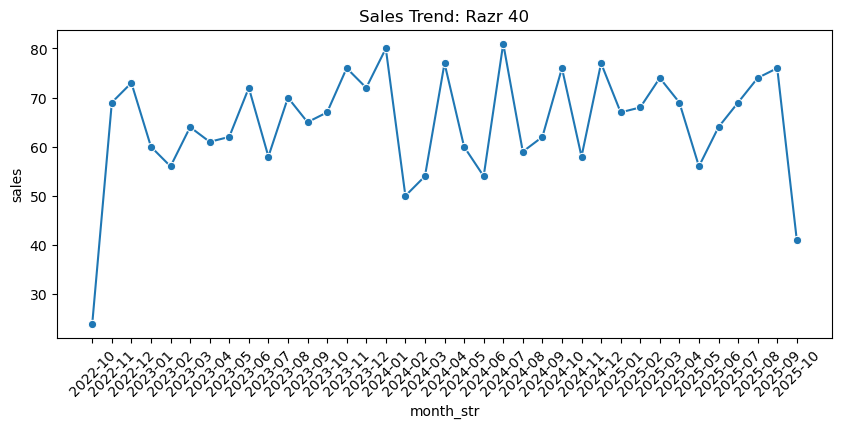

In [4]:
print("\n--- User Input Section ---")

try:
    age = int(input("Enter customer age: "))
    budget = float(input("Enter budget in INR: "))

    available_countries = sorted(df['country'].unique())
    print("Available countries:", ", ".join(available_countries))
    country = input("Enter target country: ").strip()

    if country not in available_countries:
        print("⚠ Country not found, defaulting to 'India'")
        country = "India"

    top5 = get_recommendations(age, country, budget, df, phone_stats, best_model)

    if top5 is not None:
        # VISUALIZATION FOR BEST PHONE
        best_phone = top5.iloc[0]['model']
        print(f"\n📈 SALES TREND OF BEST MODEL → {best_phone}\n")

        _, history = forecast_sales(best_phone, df)
        if history is not None:
            history['month_str'] = history['month_year'].astype(str)
            
            plt.figure(figsize=(10,4))
            sns.lineplot(x='month_str', y='sales', data=history, marker='o')
            plt.xticks(rotation=45)
            plt.title(f"Sales Trend: {best_phone}")
            plt.show()

except Exception as e:
    print("❌ Input error:", e)
